In [1]:
# Import dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow as tf
import psycopg2
import pycaret
from pycaret.classification import *

## Load Data

In [2]:
# Connect to postgres SQL database
conn = psycopg2.connect(database = 'postgres',
                        user =     'postgres',
                        password = 'Arya7328*',
                        host =     'bootcampproject.cs8v5ggqsbn0.us-west-1.rds.amazonaws.com',
                        port =     '5432')

# Create cursor object
cur = conn.cursor()

# Select all data from machine learning table
cur.execute('''
            SELECT *
            FROM ml_table;
            ''')

data = cur.fetchall()

# Create a dataframe
cols = []
for elt in cur.description:
    cols.append(elt[0])
        
health_df = pd.DataFrame (data=data,columns=cols)
pd.set_option('display.max_columns', None)
health_df.head(10)

,GENHLTH,MENTHLTH,PHYSHLTH,SEX,MARITAL_STATUS,EDUCATION,HOME_STATUS,VETERAN,EMPLOYMENT_SITUATION,INTERNET,DISABILITIES?,USEEQUIP,BLIND,ISSUES_DECISION_MAING,DIFFWALK,DIFFDRES,DIFFALON,HEALTHY_ADULTS,HEALTH_CVRAGE,DIABETE3,BLOOD_PRESSURE,_CHOLCHK,HIGH_CHOLESTEROL,CORONARY_DISEASE,ASTHMA_DISEASE,_ASTHMS1,HAS_ARTHRITIS,RACE,AGE_14LEVEL,BMI,4_BMI,CHILDREN2,EDUCATION_LEVEL,INCOME2,DRINKS_WEEK,HEAVY_DRINKER,FRUIT_CONSUMPTION,VEGGIE_COSUMPTION,PHYS_ACTIVITY_MINS,PHYS_CATEGORIES,PHYS_ACT_INDX,AER_STRGTH
0,3,88,88,2,2,6,1,2,3,1,1,2,1,1,2,2,2,1,2,3,1,2,1,2,1,3,2,1,7,2509,3,1,4,1,0.0,1,2,2,168.0,2,1,2
1,2,88,88,2,3,3,1,2,2,2,1,2,2,2,2,2,2,1,99,3,2,1,1,2,1,3,1,1,11,2652,3,1,1,4,0.0,1,1,1,330.0,1,1,2
2,2,3,88,2,3,5,1,2,7,2,2,2,2,2,2,2,2,1,99,3,2,1,2,2,1,3,2,1,11,2389,2,1,3,2,70.0,1,1,1,345.0,1,1,2
3,2,88,2,1,1,6,1,2,7,1,2,2,2,2,2,2,2,1,99,3,2,1,2,2,1,3,2,1,10,2522,3,1,4,5,0.0,1,1,1,300.0,2,1,2
4,3,88,88,2,3,4,1,2,5,1,1,2,2,2,1,2,2,1,99,3,2,1,2,2,2,1,1,1,11,2500,3,1,2,2,93.0,1,2,1,210.0,2,1,2
5,3,88,14,2,3,3,1,2,7,2,1,1,2,2,2,2,2,1,99,3,2,1,2,1,1,3,1,1,13,2579,3,1,1,99,0.0,1,1,1,90.0,3,2,4
6,3,88,88,1,1,6,1,1,7,1,2,2,2,2,2,2,2,1,99,1,1,1,1,2,1,3,1,1,13,2468,2,1,4,5,23.0,1,1,1,280.0,2,1,2
7,5,99,99,1,2,4,2,1,99,2,1,1,2,2,1,1,1,2,1,1,2,1,2,1,1,3,1,1,99,2848,3,1,2,2,0.0,1,1,1,60.0,3,2,4
8,4,30,28,2,1,6,1,2,8,1,1,2,2,1,2,2,1,2,1,3,1,1,2,2,1,3,1,1,4,3328,4,1,4,1,0.0,1,2,1,0.0,99,99,99
9,2,5,88,2,1,6,1,2,1,1,2,2,2,2,2,2,2,1,1,3,2,1,1,2,1,3,2,1,6,3328,4,1,4,5,93.0,1,2,2,180.0,2,1,1


## Check Preprocessing

In [3]:
# Check size and shape of dataframe
health_df.shape

(222168, 42)

In [4]:
# Check data types
health_df.dtypes

GENHLTH                    int64
MENTHLTH                   int64
PHYSHLTH                   int64
SEX                        int64
MARITAL_STATUS             int64
EDUCATION                  int64
HOME_STATUS                int64
VETERAN                    int64
EMPLOYMENT_SITUATION       int64
INTERNET                   int64
DISABILITIES?              int64
USEEQUIP                   int64
BLIND                      int64
ISSUES_DECISION_MAING      int64
DIFFWALK                   int64
DIFFDRES                   int64
DIFFALON                   int64
HEALTHY_ADULTS             int64
HEALTH_CVRAGE              int64
DIABETE3                   int64
BLOOD_PRESSURE             int64
_CHOLCHK                   int64
HIGH_CHOLESTEROL           int64
CORONARY_DISEASE           int64
ASTHMA_DISEASE             int64
_ASTHMS1                   int64
HAS_ARTHRITIS              int64
RACE                       int64
AGE_14LEVEL                int64
BMI                        int64
4_BMI     

In [5]:
# Double check for null values
health_df.isna().sum().sum()

0

## Feature Engineering

### For numerical, ordered data, change none code (88) to 0, change did not respond code (99) to median of the feature, and removed outliers in skewed distributions

In [6]:
# GENHLTH: values over 5 changed to the rounded median (so that it will have minimal effect on distribution)
for index, row in health_df.iterrows():
    if health_df.loc[index, 'GENHLTH'] > 5:
        health_df.loc[index, 'GENHLTH'] = round(health_df.GENHLTH.median())

In [13]:
# MENTHLTH: 88 changed to 0, 99 and over 30 dropped (since they correspond to don't know/refused)
for index, row in health_df.iterrows():
    if health_df.loc[index, 'MENTHLTH'] == 88:
        health_df.loc[index, 'MENTHLTH'] = 0
    elif (health_df.loc[index, 'MENTHLTH'] == 99) or (health_df.loc[index,'MENTHLTH'] > 30):
        health_df = health_df.drop(index)

In [15]:
# Check new number of rows (removed rows where the target value was meaningless)
health_df.shape

(219562, 42)

In [17]:
# PHYSHLTH: 88 changed to 0
for index, row in health_df.iterrows():
    if health_df.loc[index, 'PHYSHLTH'] == 88:
        health_df.loc[index, 'PHYSHLTH'] = 0

In [22]:
# PHYSHLTH: 99 and over 30 changed to new rounded median
for index, row in health_df.iterrows():
    if (health_df.loc[index, 'PHYSHLTH'] == 99) or (health_df.loc[index,'PHYSHLTH'] > 30):
        health_df.loc[index, 'PHYSHLTH'] = round(health_df.PHYSHLTH.median())

In [24]:
# AGE_14LEVEL: values over 13 changed to rounded median
for index, row in health_df.iterrows():
    if health_df.loc[index, 'AGE_14LEVEL'] > 13:
        health_df.loc[index, 'AGE_14LEVEL'] = round(health_df.AGE_14LEVEL.median())

In [25]:
# For the following columns, values over 8 changed to rounded median
change_cols = ['CHILDREN2', 'EDUCATION_LEVEL', 'INCOME2']
for col in change_cols:
    for index, row in health_df.iterrows():
        if health_df.loc[index, col] > 8:
            health_df.loc[index, col] = round(health_df[col].median())

In [27]:
# BMI: Remove outliers
for index, row in health_df.iterrows():
    if health_df.loc[index, 'BMI'] > 6000:
        health_df.loc[index, 'BMI'] = 6000

In [28]:
# PHYS_ACTIVITY_MINS: Remove outliers
for index, row in health_df.iterrows():
    if health_df.loc[index, 'PHYS_ACTIVITY_MINS'] > 5000:
        health_df.loc[index, 'PHYS_ACTIVITY_MINS'] = 5000

In [29]:
# DRINKS_WEEK: Remove outliers
for index, row in health_df.iterrows():
    if health_df.loc[index, 'DRINKS_WEEK'] > 1500:
        health_df.loc[index, 'DRINKS_WEEK'] = 1500

array([[<AxesSubplot:title={'center':'MENTHLTH'}>]], dtype=object)

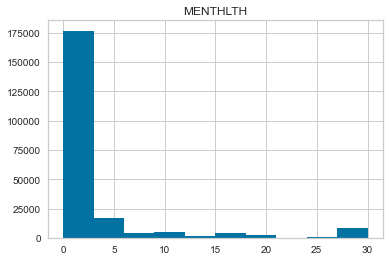

In [30]:
# Look at histogram of target (MENTHLTH) to decide bin ranges
health_df.hist(column='MENTHLTH')

In [31]:
# Create 2 bins for mental health. One at 0, one from 1-30
for index, row in health_df.iterrows():
    if health_df.loc[index,'MENTHLTH'] > 0:
        health_df.loc[index, 'MENTHLTH'] = 1

array([[<AxesSubplot:title={'center':'MENTHLTH'}>]], dtype=object)

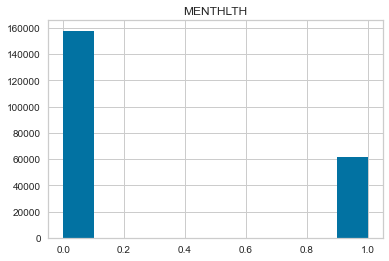

In [32]:
# Check target column bins
health_df.hist(column='MENTHLTH')

In [33]:
# Double check data types (all should be int apart from DRINKS_WEEK and PHYS_ACTIVITY_MIN)
health_df.dtypes

GENHLTH                    int64
MENTHLTH                   int64
PHYSHLTH                   int64
SEX                        int64
MARITAL_STATUS             int64
EDUCATION                  int64
HOME_STATUS                int64
VETERAN                    int64
EMPLOYMENT_SITUATION       int64
INTERNET                   int64
DISABILITIES?              int64
USEEQUIP                   int64
BLIND                      int64
ISSUES_DECISION_MAING      int64
DIFFWALK                   int64
DIFFDRES                   int64
DIFFALON                   int64
HEALTHY_ADULTS             int64
HEALTH_CVRAGE              int64
DIABETE3                   int64
BLOOD_PRESSURE             int64
_CHOLCHK                   int64
HIGH_CHOLESTEROL           int64
CORONARY_DISEASE           int64
ASTHMA_DISEASE             int64
_ASTHMS1                   int64
HAS_ARTHRITIS              int64
RACE                       int64
AGE_14LEVEL                int64
BMI                        int64
4_BMI     

In [34]:
# Check which features need to be binned in the pycaret setup (over 12 unique values)
print(health_df.nunique())

GENHLTH                     5
MENTHLTH                    2
PHYSHLTH                   30
SEX                         2
MARITAL_STATUS              7
EDUCATION                   7
HOME_STATUS                 5
VETERAN                     4
EMPLOYMENT_SITUATION        9
INTERNET                    4
DISABILITIES?               4
USEEQUIP                    4
BLIND                       4
ISSUES_DECISION_MAING       4
DIFFWALK                    4
DIFFDRES                    4
DIFFALON                    4
HEALTHY_ADULTS              3
HEALTH_CVRAGE               3
DIABETE3                    6
BLOOD_PRESSURE              3
_CHOLCHK                    3
HIGH_CHOLESTEROL            3
CORONARY_DISEASE            2
ASTHMA_DISEASE              3
_ASTHMS1                    4
HAS_ARTHRITIS               2
RACE                        9
AGE_14LEVEL                12
BMI                      2870
4_BMI                       4
CHILDREN2                   6
EDUCATION_LEVEL             4
INCOME2   

In [35]:
# Save cleaned health_df to csv
health_df.to_csv("cleaned_health_df")

## Feature Selection

In [49]:
# PyCaret Setup
# "Normalize = True" scales the data based on z-score
# "transformation = True" changes the shape of the distribution to approximately normal
# "fix_imbalance uses SMOTE to balance target variable"
# "bin_numeric_features" creates bins for continuous categorical features based on sturges rule and K-means clusters
exp_clf101 = setup(data = health_df, target = 'MENTHLTH', session_id=123,
                   normalize = True,
                   transformation = True,
                   fix_imbalance = True,
                   bin_numeric_features = ['PHYSHLTH', 'BMI', 'PHYS_ACTIVITY_MINS', 'DRINKS_WEEK'])

,Description,Value
0,Session id,123
1,Target,MENTHLTH
2,Target type,Binary
3,Original data shape,"(219562, 42)"
4,Transformed data shape,"(286789, 42)"
5,Transformed train set shape,"(220920, 42)"
6,Transformed test set shape,"(65869, 42)"
7,Numeric features,41
8,Preprocess,True
9,Imputation type,simple


In [50]:
# Create a random forest classifier
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7409,0.7098,0.2953,0.5773,0.3908,0.2475,0.2699
1,0.7502,0.7173,0.3138,0.6088,0.4142,0.2755,0.2999
2,0.7466,0.7144,0.3129,0.5942,0.4099,0.2678,0.2902
3,0.7510,0.7149,0.3151,0.6113,0.4158,0.2776,0.3022
4,0.7490,0.7131,0.3176,0.6022,0.4159,0.2750,0.2979
5,0.7471,0.7117,0.3153,0.5952,0.4122,0.2700,0.2921
6,0.7458,0.7116,0.3051,0.5936,0.4031,0.2621,0.2856
7,0.7457,0.7067,0.3056,0.5932,0.4034,0.2622,0.2856
8,0.7512,0.7144,0.3213,0.6095,0.4208,0.2812,0.3046


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

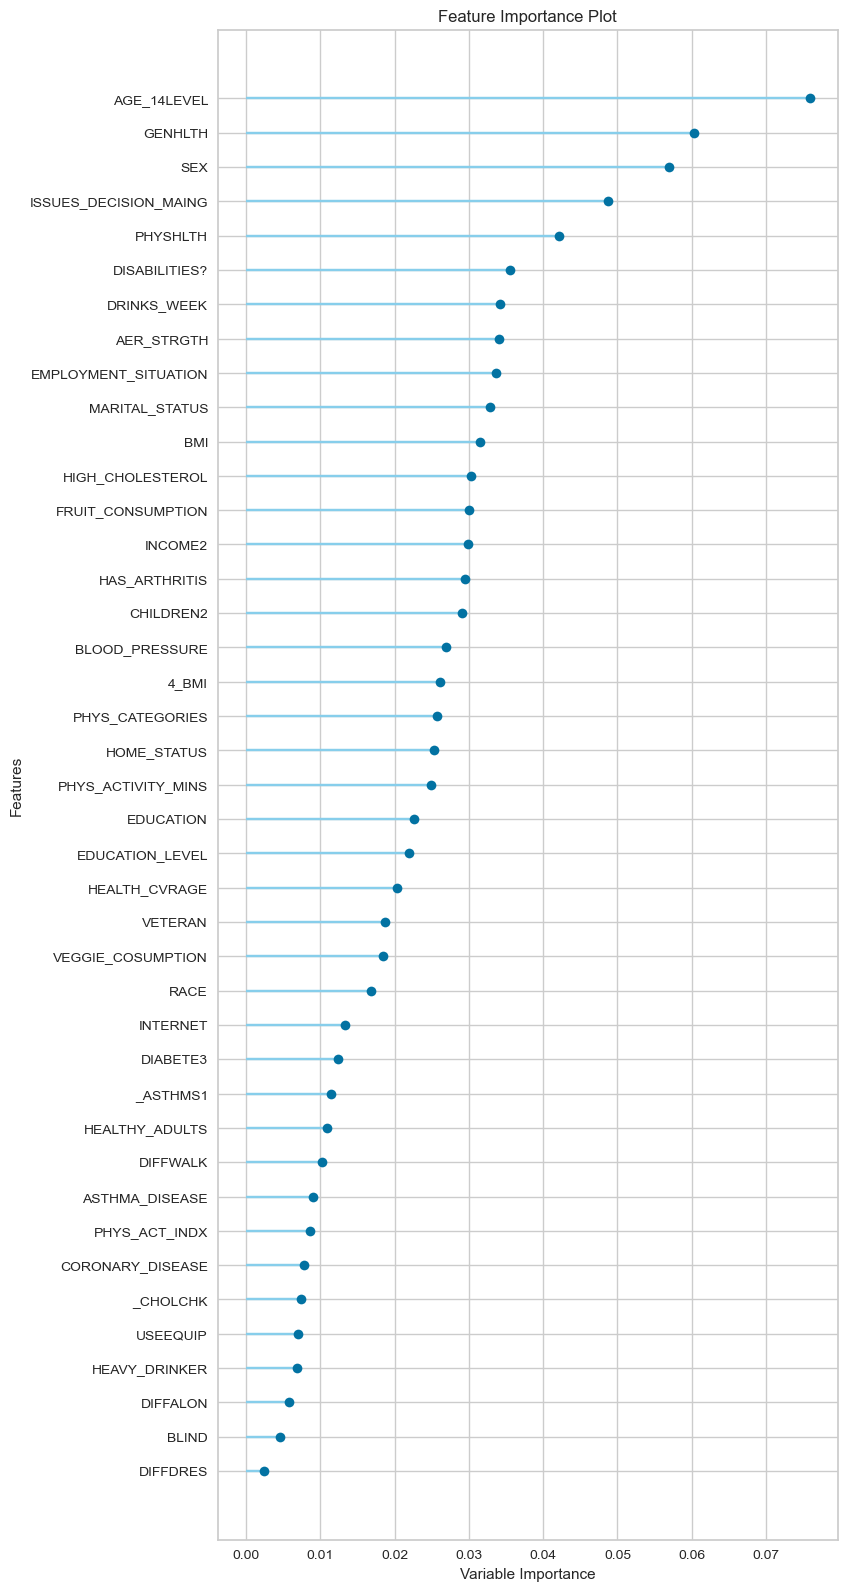

In [53]:
# Feature importance plot
plot_model(rf, plot='feature_all')

In [52]:
# Keep only 27 highest features (over 0.015 variable importance)
highest_features = ['MENTHLTH','AGE_14LEVEL','BMI','EMPLOYMENT_SITUATION','ISSUES_DECISION_MAING','GENHLTH','INCOME2', \
                    'DRINKS_WEEK','MARITAL_STATUS','AER_STRGTH','4_BMI','PHYSHLTH','PHYS_ACTIVITY_MINS','CHILDREN2', \
                    'EDUCATION','FRUIT_CONSUMPTION','EDUCATION_LEVEL','PHYS_CATEGORIES','HIGH_CHOLESTEROL', \
                    'BLOOD_PRESSURE','RACE','VEGGIE_COSUMPTION','HEALTH_CVRAGE','HOME_STATUS','DIABETE3','DISABILITIES?', \
                    'HAS_ARTHRITIS','SEX']

fs_health_df = health_df.filter(highest_features, axis=1)

## Split Data

In [54]:
# Separate data into training and testing sets
data = fs_health_df.sample(frac=0.95, random_state=123).reset_index(drop=True)
data_unseen = fs_health_df.drop(data.index, errors='ignore').reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (208584, 28)
Unseen Data For Predictions: (13462, 28)


In [55]:
# PyCaret Setup
# "normalize = True" scales the data based on z-score
# "transformation = True" changes the shape of the distribution to approximately normal
# "fix_imbalance uses SMOTE to balance target variable"
# "bin_numeric_features" creates bins for continuous categorical features based on sturges rule and K-means clusters
exp_clf101 = setup(data = data, 
                   target = 'MENTHLTH',
                   session_id=123,
                   normalize = True,
                   transformation = True,
                   fix_imbalance = True,
                   bin_numeric_features = ['PHYSHLTH', 'BMI', 'PHYS_ACTIVITY_MINS', 'DRINKS_WEEK'])

,Description,Value
0,Session id,123
1,Target,MENTHLTH
2,Target type,Binary
3,Original data shape,"(208584, 28)"
4,Transformed data shape,"(272440, 28)"
5,Transformed train set shape,"(209864, 28)"
6,Transformed test set shape,"(62576, 28)"
7,Numeric features,27
8,Preprocess,True
9,Imputation type,simple


## Compare Binary Classification Machine Learning Models

In [56]:
# Model training and selection (runtime ~35min)
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7588,0.7407,0.2993,0.6567,0.4111,0.2852,0.3201,1.5740
gbc,Gradient Boosting Classifier,0.7545,0.7357,0.3356,0.6172,0.4347,0.2950,0.3174,10.5010
rf,Random Forest Classifier,0.7437,0.7083,0.3164,0.5819,0.4099,0.2641,0.2841,9.1090
et,Extra Trees Classifier,0.7371,0.6973,0.3355,0.5542,0.4180,0.2612,0.2750,12.9070
ada,Ada Boost Classifier,0.7328,0.7233,0.4466,0.5300,0.4847,0.3061,0.3082,2.7960
dummy,Dummy Classifier,0.7187,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3610
qda,Quadratic Discriminant Analysis,0.7164,0.7219,0.5169,0.4963,0.5064,0.3076,0.3077,0.3910
nb,Naive Bayes,0.7061,0.7147,0.5155,0.4792,0.4967,0.2895,0.2899,0.2610
ridge,Ridge Classifier,0.6848,0.0000,0.6311,0.4564,0.5298,0.3018,0.3107,0.2040
lda,Linear Discriminant Analysis,0.6848,0.7309,0.6311,0.4565,0.5298,0.3018,0.3108,0.4700


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [58]:
# Create gradient boosting classifier model
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7540,0.7376,0.3482,0.6098,0.4433,0.3002,0.3196
1,0.7539,0.7312,0.3314,0.6164,0.4310,0.2917,0.3146
2,0.7545,0.7321,0.3432,0.6141,0.4403,0.2989,0.3197
3,0.7532,0.7337,0.3325,0.6134,0.4313,0.2910,0.3133
4,0.7584,0.7417,0.3420,0.6303,0.4434,0.3061,0.3294
5,0.7528,0.7372,0.3362,0.6103,0.4335,0.2920,0.3133
6,0.7566,0.7390,0.3315,0.6276,0.4339,0.2972,0.3218
7,0.7537,0.7407,0.3218,0.6201,0.4237,0.2866,0.3115
8,0.7545,0.7325,0.3392,0.6153,0.4373,0.2967,0.3182


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

## Tune Model and Analyze Performance

In [61]:
# Automatically tune model parameters using PyCaret (runtime ~50min)
tuned_gbc = tune_model(gbc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7569,0.7353,0.3153,0.6370,0.4218,0.2895,0.3182
1,0.7532,0.7258,0.3031,0.6269,0.4087,0.2759,0.3050
2,0.7527,0.7282,0.3060,0.6232,0.4104,0.2764,0.3044
3,0.7547,0.7333,0.3023,0.6346,0.4096,0.2786,0.3091
4,0.7574,0.7349,0.3106,0.6425,0.4188,0.2883,0.3187
5,0.7526,0.7374,0.3050,0.6231,0.4095,0.2756,0.3037
6,0.7562,0.7352,0.2997,0.6432,0.4088,0.2801,0.3125
7,0.7548,0.7394,0.3094,0.6311,0.4152,0.2824,0.3111
8,0.7534,0.7315,0.3017,0.6283,0.4076,0.2754,0.3050


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
# Precision Recall Curve
plot_model(tuned_gbc, plot = 'learning')

In [1]:
# Confusion Matrix
plot_model(tuned_gbc, plot = 'confusion_matrix')

NameError: name 'plot_model' is not defined

In [39]:
# Predict using held-back test sample
predict_model(tuned_gbc);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7587,0.7382,0.2678,0.6897,0.3858,0.2703,0.3172


In [40]:
# Save the model
save_model(tuned_gbc,'Final_GBC_Model_4Sep22')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=C:\Users\kylie\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['AGE_14LEVEL', 'BMI',
                                              'EMPLOYMENT_SITUATION',
                                              'ISSUES_DECISION_MAING', 'GENHLTH',
                                              'INCOME2', 'DRINKS_WEEK',
                                              'MARITAL_STATUS', 'AER_STRGTH',
                                              '4_BMI', 'PHYSHLTH',
                                              'PHYS_ACTIVITY_MINS', 'CHILDREN2',
                                              'EDUCATION', 'FRUIT_CONSU...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.1, loss='deviance',
                                             max_depth=3, max_features=None,
 